In [60]:
import numpy as np 
import pandas as pd 
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pickle
#import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler 
import torch
from torch import nn
import torch.optim as optim
import torch.utils.data as data
from sklearn.metrics import mean_absolute_error
import tqdm

In [61]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


In [62]:
window_size = 20
max_stock = 200
variables = [#'reference_price',
            #'imbalance_buy_sell_flag',
            #'target',
            #'yesterday_return',
             'yesterday_target',
             'wap_scaled',
             'reference_price'
             ]
target = 'target'
train = pd.read_csv("./data/train.csv")
stocks = range(0,max_stock)
train = train.sort_values(['date_id','time_id'])
train['wap'] = train['wap'].fillna(train['wap'].mean())
scaler =  MinMaxScaler()
targetScaler = MinMaxScaler()
returnScaler = MinMaxScaler()
#print(train.head())
train['wap_scaled'] = scaler.fit_transform(train['wap'].to_numpy().reshape(-1, 1)).squeeze()
train['target_scaled'] = targetScaler.fit_transform(train['target'].to_numpy().reshape(-1, 1)).squeeze()
train['yesterday'] = train['date_id'] - 1
merged =train.merge(train,how='left',left_on=['yesterday','stock_id','seconds_in_bucket'],right_on=['date_id','stock_id','seconds_in_bucket'],suffixes=['','_yesterday'])

train['yesterday_target'] = merged['target_yesterday']
train['return'] = train['target'] - train['yesterday_target']
train['return'] =  returnScaler.fit_transform(train['return'].to_numpy().reshape(-1, 1)).squeeze()

merged =train.merge(train,how='left',left_on=['yesterday','stock_id','seconds_in_bucket'],right_on=['date_id','stock_id','seconds_in_bucket'],suffixes=['','_2'])

train['yesterday_return'] = merged['return_2']

table = pd.pivot_table(train[train['stock_id']  < max_stock],values=variables + [target] ,columns=['stock_id'],index=['date_id','time_id'])


table.fillna(method='bfill',inplace=True)
table.fillna(method='ffill',inplace=True)

print(table.head())
table.isna().sum()
with open('targetScaler', 'wb') as handle:
    pickle.dump(targetScaler, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('wapScaler', 'wb') as handle:
    pickle.dump(scaler, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('returnScaler', 'wb') as handle:
    pickle.dump(returnScaler, handle, protocol=pickle.HIGHEST_PROTOCOL)

                reference_price                                          \
stock_id                    0         1         2         3         4     
date_id time_id                                                           
0       0              0.999812  0.999896  0.999561  1.000171  0.999532   
        1              1.000026  0.999955  0.999561  0.999870  1.000154   
        2              0.999919  0.999955  0.999351  0.999999  0.999878   
        3              1.000133  0.999896  0.999351  0.999827  0.999878   
        4              1.000455  0.999955  0.999351  1.000128  0.999878   

                                                                   ...  \
stock_id              5         6         7         8         9    ...   
date_id time_id                                                    ...   
0       0        1.000635  1.000115  0.999818  0.999916  1.000969  ...   
        1        1.001205  1.000346  1.000939  0.999916  1.001130  ...   
        2        1.001205  1.

C:\Users\adams\AppData\Local\Temp\ipykernel_18000\3377369459.py:36: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  table.fillna(method='bfill',inplace=True)
C:\Users\adams\AppData\Local\Temp\ipykernel_18000\3377369459.py:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  table.fillna(method='ffill',inplace=True)


In [63]:
rolling_target = {}
rolling_amount = 2
for stock in stocks:
    rolling_target[stock] = table[target][stock].rolling(rolling_amount).mean()
    rolling_target[stock] = rolling_target[stock].fillna(0)

rolling_target_df = pd.DataFrame(rolling_target)
print(rolling_target_df.head())

                      0         1         2         3         4         5    \
date_id time_id                                                               
0       0        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
        1       -1.319945 -3.570020 -7.925034 -2.525151 -7.034838  7.244945   
        2        2.304912 -4.040003 -6.920099 -1.535118 -3.705025  4.360080   
        3        4.835129 -5.804896 -6.099939 -0.450015 -1.640022 -1.040101   
        4        4.310012 -5.950034 -3.049970 -0.610054 -3.744960 -2.579987   

                      6          7         8         9    ...       190  \
date_id time_id                                           ...             
0       0        0.000000   0.000000  0.000000  0.000000  ...  0.000000   
        1       -3.390014  -4.985034 -3.375113  3.665090  ...  5.290508   
        2       -0.675023 -10.040104 -2.450049 -1.945198  ...  4.795193   
        3        1.745224  -9.489954 -2.605021 -5.005002  ...  1.055002

In [64]:
def create_lagged_data(data,var,window_size,target_data):
    X,y = [], []

    for i in range(data.shape[0]-window_size):
        feature = data[var[0]].iloc[i:i+window_size].to_numpy()
        target = target_data.iloc[i+window_size].to_numpy()
        X.append(feature)
        y.append(target)
    '''
    X = np.array([])
    for stock in range(max_stock):
        var_data = pd.DataFrame()
        for i in range(0,len(var)):
            var_data = pd.concat([var_data,data[var[i]][stock]],axis=1,)

        
        var_data = var_data.values.reshape(-1,len(var))
        #print(var_data)
        n = data.shape[0]
        temp_X = np.hstack(tuple([var_data[i: n-j, :] for i, j in enumerate(range(window_size,0,-1))]))
        temp_X = temp_X[:temp_X.shape[0]]
       
        if stock == 0:
            X = temp_X
        else:
            X = np.concatenate((X,temp_X),axis=1) 
    y = target_data.iloc[window_size:]
    
    
    y.reset_index()

    '''
    y_true = data['target'].iloc[window_size:]
    yesterday_target = data['yesterday_target'].iloc[window_size:]
    li_x = data[['wap_scaled','reference_price']].iloc[window_size:]
    return np.array(X), li_x.to_numpy() ,np.array(y) ,y_true.to_numpy(),yesterday_target.to_numpy()
    

In [65]:
class TimeModel(nn.Module):
    def __init__(self,window_size,features):
        super().__init__()
        self.conv1d = nn.Conv1d(window_size * 200 , 2,kernel_size=30)
        self.lstm = nn.LSTM(input_size=window_size * 200 * features, hidden_size=1000, num_layers=2, batch_first=True)
        self.linear1 = nn.Linear(window_size * 200 * features, 1)
        self.elu1 = nn.ELU()
        #self.bn1 = nn.BatchNorm1d(500)
        self.linear2 = nn.Linear(1, 200)
        self.elu2 = nn.ELU()
        #self.bn2 = nn.BatchNorm1d(400)
        self.linear3 = nn.Linear(500, 200)
        self.elu2 = nn.ELU()
        #self.bn2 = nn.BatchNorm1d(400)
        self.linear3 = nn.Linear(200, 200)

        self.to(torch.float32)
    def forward(self, x):

        x, _ = self.lstm(x)
        x = self.linear1(x)
        x = self.elu1(x)
       # x = self.bn1(x)
        x = self.linear2(x)
        #x = self.elu2(x)
        #x = self.bn2(x)
        #x = self.linear3(x)
        #x = torch.clip(x,-10,10)
        return x.type(torch.float32)

In [66]:
class TestModel(nn.Module):
    def __init__(self,window_size,features,max_stock):
        super().__init__()
        self.lstm_dic = {}
        self.lstm1 = nn.LSTM(input_size=200, hidden_size=2*window_size+1, num_layers=2, batch_first=True)

        self.sequential1 = nn.Sequential(
            nn.Linear(2*window_size+1, 1000),
            nn.ELU(),

            nn.Linear(1000, 300),
            #nn.ELU(),

            #nn.Linear(1000, 300),
            #nn.ELU(),

            #nn.Linear(500,300)
        )
        self.sequential2 = nn.Sequential(
            nn.Linear(200 * 2,500),
            nn.ELU(),
            nn.Linear(500,300),
            #nn.ELU()
            
        )

        self.output = nn.Sequential(
            nn.Linear(300 + 300, 200),
            #nn.ELU(),
            #nn.Linear(300, 200)
        )
        
        self.to(torch.float32)
    def forward(self, x, y):

        x, _ = self.lstm1(x)

        x = x[:,-1,:]

        x = self.sequential1(x)
        y = self.sequential2(y)

        out = torch.cat((x,y),dim=1)

        out = self.output(out)

        return out.type(torch.float32)

In [67]:
def train_model(window_size,LS_X_train,LS_X_test,LI_X_train,LI_X_test,y_train,y_test,features,stocks):
    model = TestModel(window_size=window_size,features=features,max_stock=stocks)
    model.to(torch.float32).to(device)
    optimizer = optim.Adam(model.parameters())
    loss_fn = nn.L1Loss()
    loader = data.DataLoader(data.TensorDataset(LS_X_train,LI_X_train, y_train), batch_size=100)
    early_stop_best = np.inf
    early_stop_count = 0
    max_stop_count = 10
    n_epochs = 2000
    for epoch in range(n_epochs):
        model.train()
        for LS_X_batch,LI_X_batch, y_batch in loader:
            LS_X_batch = LS_X_batch.to(device)
            LI_X_batch = LI_X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(LS_X_batch,LI_X_batch)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        y_pred = model(LS_X_batch,LI_X_batch)
        train_mse = loss_fn(y_pred, y_batch)
        print("Epoch %d: train MAE %.4f" % (epoch, train_mse))
        # Validation
        if epoch % 10 != 0:
            continue
        model.eval()
        with torch.no_grad():
            y_pred = model(LS_X_batch,LI_X_batch)
            train_mse = loss_fn(y_pred, y_batch)
            y_pred = model(LS_X_test,LI_X_test)
            test_mse = loss_fn(y_pred, y_test.to(device))
            if test_mse < early_stop_best:
                best_model = model
                early_stop_best = test_mse
                early_stop_count = 0 
                print('best loss:',early_stop_best)
                torch.save(best_model.state_dict(), './lstm_model')
        print("test MAE %.4f" % (test_mse))
        early_stop_count += 1
        print(early_stop_count)
        if early_stop_count >= max_stop_count:
            return best_model

    return best_model

In [68]:

#for stock in stocks:
torch.cuda.empty_cache()
#print("creating forecaster for stock: ",stock)
#X, y, y_true = create_lagged_data(table,['wap_scaled'],window_size,0,target=rolling_target_df)
X, li_X, y, y_true,yesterday_target = create_lagged_data(table,variables,window_size,target_data=rolling_target_df)


size = int(X.shape[0]*.9)
LS_X_train = torch.tensor(X[:size]).to(torch.float32).to(device) 
y_train = torch.tensor(y[:size]).to(torch.float32).to(device)
y_train_true = y[:size]
LI_X_train = torch.tensor(li_X[:size]).to(torch.float32).to(device)
yesterday_target_train = yesterday_target[:size]

LS_X_test = torch.tensor(X[size:]).to(torch.float32).to(device)
y_test = torch.tensor(y[size:]).to(torch.float32).to(device)
y_test_true = y_true[size:]
LI_X_test = torch.tensor(li_X[size:]).to(torch.float32).to(device)
yesterday_target_test = yesterday_target[size:]



In [69]:

forecaster = train_model(window_size,LS_X_train,LS_X_test,LI_X_train,LI_X_test,y_train,y_test,features=len(variables),stocks=max_stock)


Epoch 0: train MAE 4.9504
best loss: tensor(5.6308, device='cuda:0')
test MAE 5.6308
1
Epoch 1: train MAE 4.9515
Epoch 2: train MAE 4.9585
Epoch 3: train MAE 4.9229
Epoch 4: train MAE 4.9098
Epoch 5: train MAE 4.9207
Epoch 6: train MAE 4.8910
Epoch 7: train MAE 4.8760
Epoch 8: train MAE 4.8696
Epoch 9: train MAE 4.8463
Epoch 10: train MAE 4.8173
test MAE 5.8318
2
Epoch 11: train MAE 4.8334
Epoch 12: train MAE 4.8243
Epoch 13: train MAE 4.8228
Epoch 14: train MAE 4.8364
Epoch 15: train MAE 4.8081
Epoch 16: train MAE 4.8083
Epoch 17: train MAE 4.8186
Epoch 18: train MAE 4.8282
Epoch 19: train MAE 4.7973
Epoch 20: train MAE 4.7906
test MAE 5.8552
3
Epoch 21: train MAE 4.7848
Epoch 22: train MAE 4.7817
Epoch 23: train MAE 4.7940
Epoch 24: train MAE 4.7573
Epoch 25: train MAE 4.7668
Epoch 26: train MAE 4.7640
Epoch 27: train MAE 4.7583
Epoch 28: train MAE 4.7447
Epoch 29: train MAE 4.7438
Epoch 30: train MAE 4.7345
test MAE 5.9132
4
Epoch 31: train MAE 4.7541
Epoch 32: train MAE 4.7398
Epoc

In [70]:
y_hat = forecaster(LS_X_test,LI_X_test).to('cpu').detach().numpy()


#ra = 0
#y_hat[y_hat >= ra] = ra
#y_hat[y_hat <= -ra] = -ra


print(mean_absolute_error(y_test.to('cpu').detach().numpy(),y_hat) )
#mean_absolute_error(y_train.to('cpu').detach().numpy(),y_train_hat.to('cpu').detach().numpy())

6.0294404


In [71]:
torch.save(forecaster.state_dict(), './lstm_model')

6.0294404


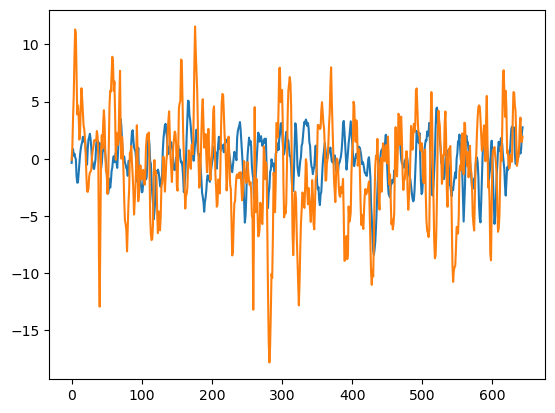

In [72]:
inversed_y_hat = y_hat
inversed_y_test = y_test.cpu()
print(mean_absolute_error(inversed_y_test,inversed_y_hat) )
pd.Series(inversed_y_hat[:,0][2000:]).plot()
pd.Series(inversed_y_test[:,0][2000:]).plot()
plt.show()

In [73]:

print(yesterday_target.shape)
y_hat = returnScaler.inverse_transform(forecaster(LS_X_test,LI_X_test).to('cpu').detach().numpy()) + yesterday_target_test
print(y_hat.shape)

ra = 20
y_hat[y_hat >= ra] = ra
y_hat[y_hat <= -ra] = -ra


print(mean_absolute_error(y_test_true,y_hat) )

(26435, 200)
(2644, 200)
20.238688999366115


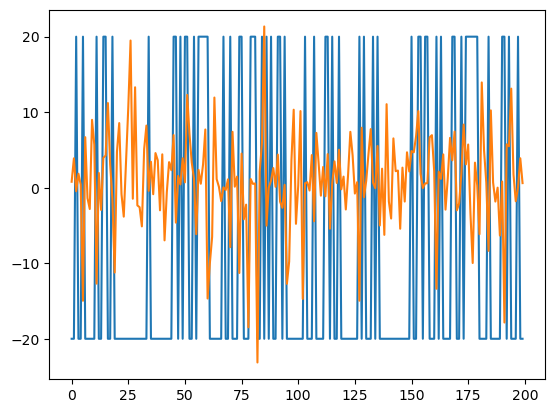

In [74]:

y_hat = y_hat
y_test_true = y_test_true
pd.Series(y_hat[2620:][1]).plot()
pd.Series(y_test_true[2620:][1]).plot()
plt.show()